## Image Caption Generation

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils
from PIL import Image

Detect which device (CPU/GPU) to use.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
#EncoderCNN class is defined here
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        
        # Load the pretrained ResNet-50 and replace top fc layer
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]  # Remove last layer
        modules.append(nn.Identity())
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        return features

In [4]:
# instantiate encoder and put into evaluation mode.
encoder = EncoderCNN().to(device)
encoder.eval()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [5]:
data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224), 
    transforms.CenterCrop(224), 
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [6]:
# Get unique images from the csv for extracting features - helper code
imageList = pd.read_csv("/kaggle/input/dataset/coco_subset_meta.csv")
imageList['file_name']
len(imageList.id.unique())

imagesUnique = sorted(imageList['file_name'].unique())

df_unique_files =  pd.DataFrame.from_dict(imagesUnique)

df_unique_files.columns = ['file_name']
df_unique_files

,file_name
0,000000000009.jpg
1,000000000025.jpg
2,000000000030.jpg
3,000000000034.jpg
4,000000000036.jpg
...,...
5063,000000581906.jpg
5064,000000581909.jpg
5065,000000581913.jpg
5066,000000581921.jpg


In [7]:
# Define a class COCOImagesDataset(Dataset) function that takes the 
# image file names and reads the image and apply transform to it

IMAGE_DIR = "/kaggle/input/dataset/coco/images"

class COCOImagesDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform


    def __getitem__(self, index):
        filename = self.df.iloc[index]['file_name']
        image_path = os.path.join(IMAGE_DIR, filename)
        image = Image.open(image_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, filename

    def __len__(self):
        return len(self.df)
    

In [8]:
# Use Dataloader to use the unique files using the class COCOImagesDataset
# make sure that shuffle is False as we are not aiming to retrain in 
# this exercise

coco_dataset = COCOImagesDataset(df_unique_files, transform=data_transform)
coco_dataloader = DataLoader(coco_dataset, batch_size=64, shuffle=False, num_workers=2)


In [9]:
# # Apply encoder to extract featues and save them (e.g., you can save it using image_ids)
# # Hint - make sure to save your features after running this - you can use torch.save to do this

# features_map = dict()
# from tqdm.notebook import tqdm
# from PIL import Image

# with torch.no_grad():
#     for i, (images, filenames) in enumerate(coco_dataloader):
#         images = images.to(device).float()
#         features = encoder(images)
#         for j in range(len(features)):
#             image_id = os.path.splitext(filenames[j])[0]
#             features_map[image_id] = features[j].cpu().numpy()
            
# # Save the features map
# torch.save(features_map, 'features.pth')

# load the features map
features_map = torch.load("/kaggle/input/features/features.pth")

In [10]:
import json

# loading captions for training
with open('/kaggle/input/dataset/coco/annotations2017/captions_train2017.json', 'r') as json_file:
    data = json.load(json_file)
    
df = pd.DataFrame.from_dict(data["annotations"])
df.head()

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


In [11]:
# Hint: get the filename matching id from coco_subset_meta.csv - make sure that for each id you add image filename
coco_subset = pd.read_csv("/kaggle/input/dataset/coco_subset_meta.csv")
coco_subset = coco_subset.rename(columns={"id": "img_id"})

In [12]:
#The data from captions_train2017.json file is merged with the coco_subset_meta.csv file on the image_id column 
#The resulting DataFrame 'new_file' contains columns for Image ID, ID, Caption, and Filename

new_file = pd.merge(df, coco_subset, how="inner", left_on="image_id", right_on="img_id")[["image_id","id","caption","file_name"]]
new_file.head(10)

,image_id,id,caption,file_name
0,57429,2049,An airplane with its landing wheels out landing.,000000057429.jpg
1,57429,2139,A plane that is taking off at an airport,000000057429.jpg
2,57429,2946,A man takes a picture of an airplane taking off.,000000057429.jpg
3,57429,5520,A large jet takes off from an airport runway.,000000057429.jpg
4,57429,821117,The airplane is taking off on the runway at th...,000000057429.jpg
5,410627,2961,The young man is stirring his pot of food with...,000000410627.jpg
6,410627,6444,A man enjoys cooking food in a pan,000000410627.jpg
7,410627,8523,A smiling man is cooking in his kitchen.,000000410627.jpg
8,410627,8649,A man smiles as he stirs his food in the pot.,000000410627.jpg
9,410627,826886,A boy smiles while holding a pot and spoon.,000000410627.jpg


In [13]:
new_file["clean_caption"] = "" # add a new column to the dataframe for the cleaned captions

def gen_clean_captions_df(df):

    # Remove spaces in the beginning and at the end
    # Convert to lower case
    # Replace all non-alphabet characters with space
    # Replace all continuous spaces with a single space

    clean_captions = []
    for caption in df['caption']:
        caption = caption.strip().lower()
        clean_caption = ''.join([c if c.isalpha() else ' ' for c in caption])
        clean_caption = ' '.join(clean_caption.split())
        clean_captions.append(clean_caption)

    # add to dataframe
    df["clean_caption"] = clean_captions

    return df


In [14]:
# clean and print 10 of these
new_file = gen_clean_captions_df(new_file)
new_file.head(10)

,image_id,id,caption,file_name,clean_caption
0,57429,2049,An airplane with its landing wheels out landing.,000000057429.jpg,an airplane with its landing wheels out landing
1,57429,2139,A plane that is taking off at an airport,000000057429.jpg,a plane that is taking off at an airport
2,57429,2946,A man takes a picture of an airplane taking off.,000000057429.jpg,a man takes a picture of an airplane taking off
3,57429,5520,A large jet takes off from an airport runway.,000000057429.jpg,a large jet takes off from an airport runway
4,57429,821117,The airplane is taking off on the runway at th...,000000057429.jpg,the airplane is taking off on the runway at th...
5,410627,2961,The young man is stirring his pot of food with...,000000410627.jpg,the young man is stirring his pot of food with...
6,410627,6444,A man enjoys cooking food in a pan,000000410627.jpg,a man enjoys cooking food in a pan
7,410627,8523,A smiling man is cooking in his kitchen.,000000410627.jpg,a smiling man is cooking in his kitchen
8,410627,8649,A man smiles as he stirs his food in the pot.,000000410627.jpg,a man smiles as he stirs his food in the pot
9,410627,826886,A boy smiles while holding a pot and spoon.,000000410627.jpg,a boy smiles while holding a pot and spoon


In [15]:
import random
import math
torch.manual_seed(42)
def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)
    
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)
    
    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [16]:
# Get unique image IDs
unique_image_ids = new_file['image_id'].unique()

# Split IDs into train/validation/test sets
train_ids, valid_ids, test_ids = split_ids(unique_image_ids, train=0.7, valid=0.1, test=0.2)

# Concatenate train and valid sets
train_val_ids = np.concatenate((train_ids, valid_ids))

# Use the IDs to split the dataframe into train/validation/test sets
train_set = new_file[new_file['image_id'].isin(train_ids)]
valid_set = new_file[new_file['image_id'].isin(valid_ids)]
test_set = new_file[new_file['image_id'].isin(test_ids)]

#create a combined set of train and validation sets
train_val_set = new_file[new_file['image_id'].isin(train_val_ids)]

In [17]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            # this will convert each word to index and index to word as you saw in the tutorials
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


In [18]:
# [Hint] building a vocab function such with frequent words e.g., setting MIN_FREQUENCY = 3
MIN_FREQUENCY = 3

def build_vocab(df_ids, new_file):
    """ 
    Parses training set token file captions and builds a Vocabulary object and dataframe for 
    the image and caption data

    Returns:
        vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
    """
    word_mapping = Counter()

    # for index in df.index:
    for index, id in enumerate(df_ids):
        caption = str(new_file.loc[new_file['image_id']==id]['clean_caption'])
        for word in caption.split():
            # We use isalpha() to get rid of numbers, symbols etc.
            if word.isalpha():
                if word in word_mapping:
                    word_mapping[word] += 1
                else:
                    word_mapping[word] = 1

    # create a vocab instance
    vocab = Vocabulary()

    # add the words to the vocabulary
    for word in word_mapping:
        # Ignore infrequent words to reduce the embedding size
        if word_mapping[word] > MIN_FREQUENCY:
            vocab.add_word(word)
    return vocab

In [19]:
# build your vocabulary for train, valid and test sets

# build vocabulary for training set
train_vocab = build_vocab(train_ids, train_set)

# build vocabulary for validation set
valid_vocab = build_vocab(valid_ids, valid_set)

# build vocabulary for train+validation set
train_val_vocab = build_vocab(train_val_ids, train_val_set)

In [20]:
MAX_SEQ_LEN = 47


class COCO_Features(Dataset):
    """COCO subset custom dataset, compatible with torch.utils.data.DataLoader."""

    def __init__(self, df, vocab, features):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)
            features: image features
            vocab: vocabulary wrapper

        """
        self.df = df
        self.filename = df["file_name"].unique()
        self.features = features
        self.vocab = vocab
        self.max_seq_len = MAX_SEQ_LEN

    def __getitem__(self, index):
        """Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length)"""

        filename = self.df.iloc[index]["file_name"]
        img_id = filename.split(".")[0]

        # get the image features
        image_feature = self.features[img_id]

        # convert the NumPy array to a PyTorch tensor
        imgage_feature_tensor = torch.from_numpy(image_feature)

        # get the caption at the current index
        caption = self.df.iloc[index]["clean_caption"]

        # convert caption to word IDs
        caption = [self.vocab(word) for word in caption.split()]
        caption.append(self.vocab("<end>"))

        caption_tensor = torch.tensor(caption)

        return imgage_feature_tensor, caption_tensor

    def __len__(self):
        return len(self.filename)


In [21]:
def caption_collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption).
            - image: torch tensor of shape (3, 224, 224).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 224, 224).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: len(x[1]), reverse=True)

    # Separate features and captions
    features, captions = zip(*data)

    # Merge features into a single tensor
    features = torch.stack(features)

    # Merge captions into a single tensor and pad them with zeroes
    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), MAX_SEQ_LEN).long()
    for i, caption in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = caption[:end]
    lengths = torch.tensor(lengths)

    return features, targets, lengths

In [22]:
BATCH_SIZE=64

# create dataset and dataloader for training set
dataset_train = COCO_Features(
    df=train_set,
    vocab=train_vocab,
    features=features_map,
)
dataloader_train = DataLoader(
    dataset=dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=caption_collate_fn,
    drop_last=True
)

# create dataset and dataloader for validation set
dataset_valid = COCO_Features(
    df=valid_set,
    vocab=train_val_vocab,
    features=features_map,
)
dataloader_valid = DataLoader(
    dataset=dataset_valid,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=caption_collate_fn,
    drop_last=True
)

In [23]:
train_iter = iter(dataloader_train)
images, captions, lengths = next(train_iter)

print("Image features shape:", images.shape)
print("Caption shape:", captions.shape)
print("Lengths shape:", lengths.shape)
print("Lengths:", lengths)

Image features shape: torch.Size([64, 2048])
Caption shape: torch.Size([64, 47])
Lengths shape: torch.Size([64])
Lengths: tensor([17, 15, 15, 14, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9])


In [24]:
#DecoderRNN class is used to generate captions for given image features using an RNN model.

class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last convolutional layer (flattened to dimensions after AdaptiveAvgPool2d that may give you => 1 x 1 x 2048, other layers are also accepted but this will affect your accuracy!)
        # into a Linear layer to resize
        self.resize = nn.Linear(in_features=2048, out_features=embed_size)
        
        # batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.0001)

        #embedding layer
        self.embed = nn.Embedding(vocab_size,embed_size)

        #RNN layer
        self.rnn = nn.RNN(embed_size,hidden_size,num_layers,batch_first=True)

        # self.linear: linear layer with input: hidden layer, output: vocab size
        self.linear = nn.Linear(hidden_size, vocab_size)
        
        self.bn = nn.Identity()
        
        self.max_seq_length = max_seq_length

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        
        embeddings = self.embed(captions)
        features = self.resize(features)
        features = self.bn(features)
        
        # Concatenate image features and captions along sequence length dimension
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)

        # compute your feature embeddings
        # pack_padded_sequence returns a PackedSequence object, which contains two items:
        # the packed data (data cut off at its true length and flattened into one list), and
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data
        # [a, x, b, c] with batch_sizes=[2,1,1].
        
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)

        hiddens, _ = self.rnn(packed)
        outputs = self.linear(hiddens[0])  # hint: use a hidden layers in parenthesis
        return outputs

    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(0)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))  # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)  # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)  # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)  # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)  # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [25]:
# instantiate decoder
decoder = DecoderRNN(vocab_size=len(train_val_vocab)).to(device)

In [26]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(decoder.parameters(), lr=0.0001)

# Train the model
epochs = 100
train_losses = []
validation_losses = []
best_validation_loss = np.inf
patience = 5
no_improvement_in_epoc = 0
for epoch in range(epochs):
    decoder.train()
    epoch_train_loss = 0.0
    for i, (features, captions, lengths) in enumerate(dataloader_train):
        # Move the data to the device (CPU or GPU) being used
        features = features.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0].to(device)

        # Forward pass
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs.view(-1, len(train_val_vocab)), targets)
        #loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the training loss
        epoch_train_loss += loss.item()

    # Compute the validation loss
    epoch_validation_loss = 0.0
    decoder.eval()
    with torch.no_grad():
        for i, (features, captions, lengths) in enumerate(dataloader_valid):
            # Move the data to the device (CPU or GPU) being used
            features = features.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0].to(device)

            # Forward pass
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs.view(-1, len(train_val_vocab)), targets)
            #loss = criterion(outputs, targets)

            # Record the validation loss
            epoch_validation_loss += loss.item()

    # Print the epoch loss
    epoch_train_loss /= len(dataloader_train)
    epoch_validation_loss /= len(dataloader_valid)
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'
          .format(epoch+1, epochs, epoch_train_loss, epoch_validation_loss))
    
    # Record the losses for plotting
    train_losses.append(epoch_train_loss)
    validation_losses.append(epoch_validation_loss)
    
    # Check if the validation loss has improved
    if epoch_validation_loss < best_validation_loss:
        best_validation_loss = epoch_validation_loss
        no_improvement_in_epoc = 0
    else:
        no_improvement_in_epoc += 1
        # Stop training if the validation loss hasn't improved for `patience` epochs
        if no_improvement_in_epoc == patience:
            print('Validation loss has not improved for {} epochs. Stopping training.'.format(patience))
            break

Epoch [1/100], Train Loss: 6.4234, Val Loss: 5.3287
Epoch [2/100], Train Loss: 4.7431, Val Loss: 5.0376
Epoch [3/100], Train Loss: 4.4953, Val Loss: 4.9012
Epoch [4/100], Train Loss: 4.3061, Val Loss: 4.7741
Epoch [5/100], Train Loss: 4.1372, Val Loss: 4.6927
Epoch [6/100], Train Loss: 4.0042, Val Loss: 4.6346
Epoch [7/100], Train Loss: 3.8925, Val Loss: 4.5972
Epoch [8/100], Train Loss: 3.7971, Val Loss: 4.5724
Epoch [9/100], Train Loss: 3.7080, Val Loss: 4.5383
Epoch [10/100], Train Loss: 3.6220, Val Loss: 4.5264
Epoch [11/100], Train Loss: 3.5433, Val Loss: 4.5124
Epoch [12/100], Train Loss: 3.4692, Val Loss: 4.4928
Epoch [13/100], Train Loss: 3.3988, Val Loss: 4.4823
Epoch [14/100], Train Loss: 3.3340, Val Loss: 4.4747
Epoch [15/100], Train Loss: 3.2688, Val Loss: 4.4693
Epoch [16/100], Train Loss: 3.2057, Val Loss: 4.4633
Epoch [17/100], Train Loss: 3.1426, Val Loss: 4.4611
Epoch [18/100], Train Loss: 3.0862, Val Loss: 4.4559
Epoch [19/100], Train Loss: 3.0270, Val Loss: 4.4607
Ep

In [27]:
# Save the checkpoint
decoder_checkpoint = {
    'epoch': epoch + 1,
    'decoder_state_dict': decoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': validation_losses
}
torch.save(decoder_checkpoint, 'decoder_checkpoint.pth')

In [28]:
# Load the saved model
decoder_loaded = DecoderRNN(vocab_size=len(train_val_vocab)).to(device)

# Load the saved checkpoint
checkpoint = torch.load('decoder_checkpoint.pth')

# Load the model state dictionary and optimizer state dictionary
decoder_loaded.load_state_dict(checkpoint['decoder_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Load the training and validation losses
train_losses = checkpoint['train_losses']
validation_losses = checkpoint['val_losses']

# Get the epoch number of the saved checkpoint
start_epoch = checkpoint['epoch']

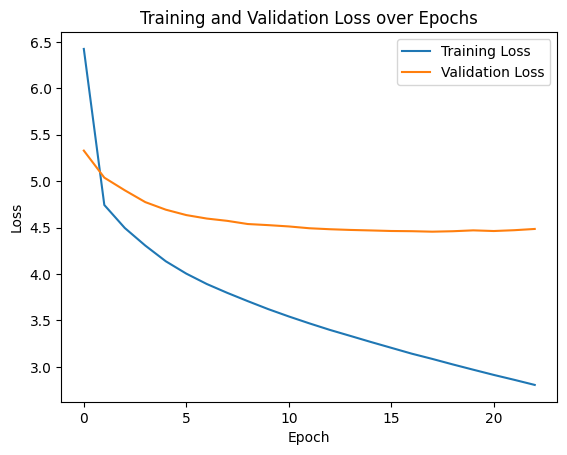

In [29]:
# plot training and validation loss over epochs
plt.plot(train_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend(loc='upper right')
plt.show()

The stopping point here can be justified based on the validation loss not improving for 5 consecutive epochs. This means that the model has reached a point where further training might not improve the performance of the model.

Early stopping helps to prevent overfitting, where the model becomes too specialized to the training data and performs poorly on new, unseen data.

In [30]:
#Function to generate captions
def generate_caption(features, decoder, device):
    predicted_captions = []
    with torch.no_grad():
        #move features to device
        features = features.to(device)
        
        #captions generated using the sample function of DecoderRNN class
        predicted_captions_ids = decoder.sample(features)
        predicted_captions_ids = predicted_captions_ids.cpu().numpy()

        #convert tokens into words
        p_caption = []
        for word_idx in predicted_captions_ids[0]:
            word = train_val_vocab.idx2word[word_idx.item()]
            if word == '<end>':
                break
            if word != '<unk>':
                p_caption.append(word)
        caption = ' '.join(p_caption[1:-1])
        predicted_captions.append(caption)
        return predicted_captions
    

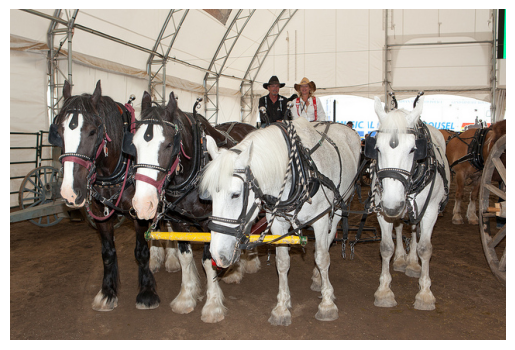


Predicted caption: man and a woman standing in a

Reference captions:
several hoses are attached to carts with people behind them
A team of four horses hooked up to a wagon.
A group of horses are pulling two people on a wagon.
Clydesdale horses standing side by side with two people. 
a group of horses standing next to each other 




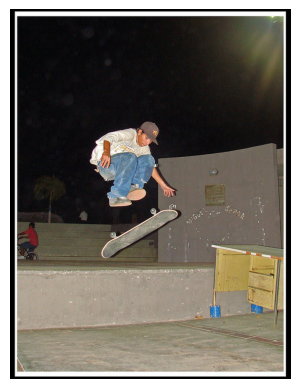


Predicted caption: man with a of

Reference captions:
Aerial jump performed by skateboarder at night time.
a man on a skate board doing a trick in the air 
a man is doing a trick on a skateboard
A person riding a skateboard on the cement.
A man with a hat in the air with a skateboard.




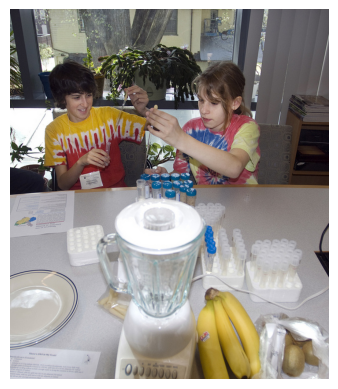


Predicted caption: white toddler and a prepared sitting on a

Reference captions:
Two kids seated next to a table with a blender, banana and eggs 
Two kids play next to a table with a blender, eggs and bananas
A white table topped with fruit and tools near two kids.
A couple of kids at a table with a blender.
Two young people are playing around near a blender and some bananas. 
The children are getting ready to make something in the blender. 




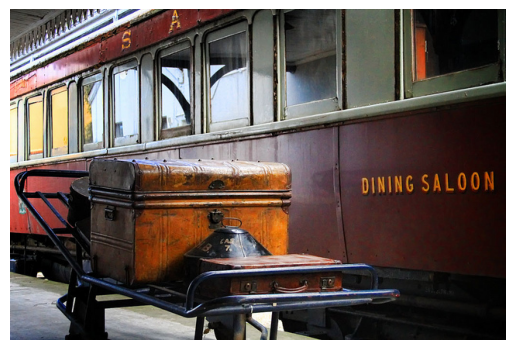


Predicted caption: train is sitting on a

Reference captions:
A truck and luggage sitting on a cart by the dining saloon car of a train.
a trunk is on a cart outside a train
A brown trunk sitting on a cart next to a red train.
A buggy of luggage sitting outside a restaurant. 
Antique luggage on a cart in front of an antique train.




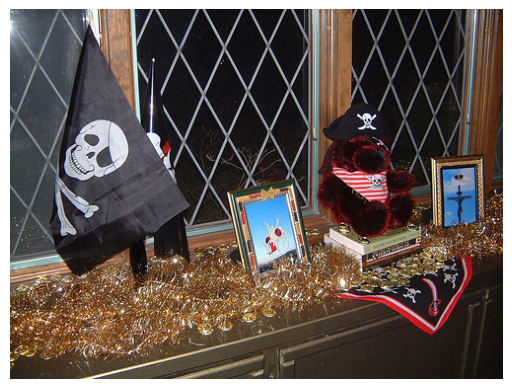


Predicted caption: group of people standing next to a

Reference captions:
various pirate decor is on the top of a table
A window sill decorated with skull and cross bones items
A window sill filled with a pirate flag and a stuffed teddy bear.
A cabinet has a couple of pictures, a stuffed animal and a pirate flag on it.
A couple of things on a counter top on display.




In [31]:
import random

# select 5 random images from test set
test_image_file_names = random.sample(test_set["file_name"].tolist(), k=5)

# generate predictions for 5 random images and display results
for file_name in test_image_file_names:
    
    image_id = file_name.split(".")[0]
    
    # get image features
    features = features_map[image_id]
    features = torch.from_numpy(features).unsqueeze(0)
    
    predicted_caption = generate_caption(features, decoder_loaded, device)
    
    # get reference captions for image
    image_references = []
    matching_rows = test_set[test_set['file_name'].str.contains(file_name)]

    # extract the captions for the matching rows
    image_references = matching_rows['caption'].tolist()

    # display image and captions
    image = Image.open('/kaggle/input/dataset/coco/images/'+ file_name)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    print("\nPredicted caption:", " ".join(predicted_caption))
    print("\nReference captions:")
    image_references_set = set(image_references)
    for reference in image_references_set:
        print(reference)
    print("\n")

In [32]:
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import warnings
warnings.filterwarnings('ignore')

test_filenames = test_set['file_name'].unique()
bleu_scores = []
stats = pd.DataFrame(columns=['ref', 'preds', 'bleu'])

for i, image in enumerate(test_filenames):
    file_name = image[:-4]
    features = features_map[file_name]
    features = torch.from_numpy(features).unsqueeze(0)
    predicted_caption = generate_caption(features, decoder_loaded, device)
    image_references = []
    reference_cap = test_set[test_set['file_name'].str.contains(image)]
    image_references = reference_cap['caption'].tolist()

    bleu_score = np.mean([sentence_bleu([ref.split()], gen.split()) for ref in image_references for gen in predicted_caption])
    #bleu_scores.append(bleu_score)
    stats = stats.append({'ref': image_references, 'preds': predicted_caption, 'bleu': bleu_score}, ignore_index=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Average BLEU score: 0.3087186087973085


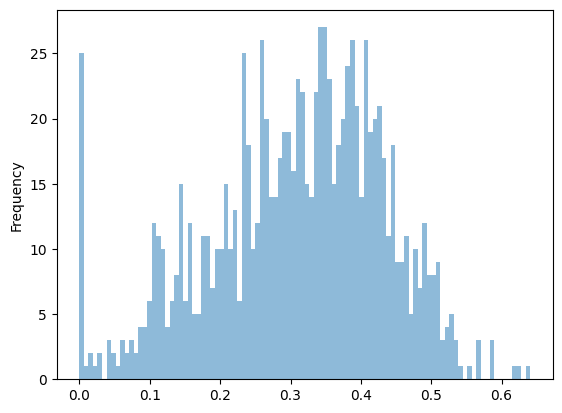

In [33]:
# Calculate average BLEU score over the whole test set
print("Average BLEU score:", stats['bleu'].mean())

#Histogram of the distribution of BLEU scores over the entire test set
ax = stats['bleu'].plot.hist(bins=100, alpha=0.5)

In [34]:
# Sort the DataFrame based on the 'bleu' column in descending order
sorted_stats = stats.sort_values(by='bleu', ascending=False)

# Get the sample with the highest BLEU score
highest_bleu_sample = sorted_stats.iloc[0]

# Get the sample with the lowest BLEU score
lowest_bleu_sample = sorted_stats.iloc[-1]

# Display the information for the highest BLEU score sample
print("Sample with Highest BLEU Score:")
print("Predicted Caption:", highest_bleu_sample['preds'])
print("BLEU Score:", highest_bleu_sample['bleu'])
print("Reference Captions:")
final_set = set(highest_bleu_sample['ref'])
for i, ref_caption in enumerate(final_set):
    print(f"Reference {i+1}: {ref_caption}")
print()

# Display the information for the lowest BLEU score sample
print("Sample with Lowest BLEU Score:")
print("Predicted Caption:", lowest_bleu_sample['preds'])
print("BLEU Score:", lowest_bleu_sample['bleu'])
print("Reference Captions:")
final_set = set(lowest_bleu_sample['ref'])
for i, ref_caption in enumerate(final_set):
    print(f"Reference {i+1}: {ref_caption}")

Sample with Highest BLEU Score:
Predicted Caption: ['kitchen with a throwing and a throwing and a']
BLEU Score: 0.6408845355398519
Reference Captions:
Reference 1: A bearded man holds a baby in a small kitchen area.
Reference 2: Man holding a baby near the kitchen stove.
Reference 3: A man carrying a baby in a sling in a kitchen.
Reference 4: A man is holding a small child in a kitchen.
Reference 5: A man holding a baby in a kitchen.

Sample with Lowest BLEU Score:
Predicted Caption: ['people are walking around']
BLEU Score: 0.0
Reference Captions:
Reference 1: A man is surfing a large wave towards the shore.
Reference 2: A man is riding the waves on a surfboard.
Reference 3: A man riding a wave on a surfboard.
Reference 4: A man in a wet suit surfing over waves.
Reference 5: A man in a black wet suit rides a small wave in the ocean.


In [35]:
from sklearn.metrics.pairwise import cosine_similarity

test_filenames = test_set['file_name'].unique()
cosine_similarities = []
stats['cos_sim'] = np.nan

for i, image in enumerate(test_filenames):
    file_name = image[:-4]
    features = features_map[file_name]
    features = torch.from_numpy(features).unsqueeze(0)
    
    predicted_caption = generate_caption(features, decoder_loaded, device)
    
    image_references = []
    reference_cap = test_set[test_set['file_name'].str.contains(image)]
    image_references = reference_cap['caption'].tolist()

    predicted_vectors = []
    for word in predicted_caption[0]:
        if isinstance(word, str):
            word = train_val_vocab.word2idx.get(word, train_val_vocab.word2idx['<unk>'])  # Assign a special "unknown" token index
        word_vector = decoder.embed.weight.data[word].cpu().numpy()  # Move tensor to CPU and convert to NumPy array
        predicted_vectors.append(word_vector)
    predicted_average_vector = np.mean(predicted_vectors, axis=0)

    reference_vectors = []
    for reference in image_references:
        reference_words = reference.split()
        reference_vectors_per_word = []
        for word in reference_words:
            word = train_val_vocab.word2idx.get(word, train_val_vocab.word2idx['<unk>'])  # Assign a special "unknown" token index
            word_vector = decoder.embed.weight.data[word].cpu().numpy()  # Move tensor to CPU and convert to NumPy array
            reference_vectors_per_word.append(word_vector)
        reference_average_vector = np.mean(reference_vectors_per_word, axis=0)
        similarity = cosine_similarity([predicted_average_vector], [reference_average_vector])[0][0]
        cosine_similarities.append(similarity)
    stats.at[i, 'cos_sim'] = np.mean(cosine_similarities)

Average Cosine Similarity: 0.583476132066379


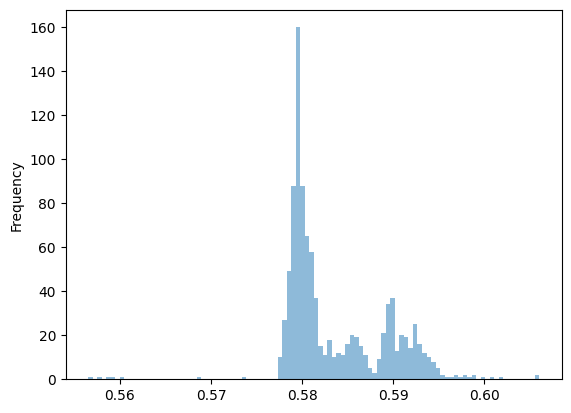

In [36]:
# Calculate average cosine similarity over the whole test set
print("Average Cosine Similarity:", stats['cos_sim'].mean())

#Histogram of the distribution of cosine similarity scores over the entire test set
ax = stats['cos_sim'].plot.hist(bins=100, alpha=0.5)

In [37]:
# Sort the DataFrame based on the 'cos_sim' column in descending order
sorted_stats = stats.sort_values(by='cos_sim', ascending=False)

# Get the sample with the highest cosine similarity
highest_cossim_sample = sorted_stats.iloc[0]

# Get the sample with the lowest cosine similarity
lowest_cossim_sample = sorted_stats.iloc[-1]

# Display the information for the highest cosine similarity sample
print("Sample with Highest Cosine Similarity:")
print("Predicted Caption:", highest_cossim_sample['preds'])
print("Cosine Similarity:", highest_cossim_sample['cos_sim'])
print("Reference Captions:")
final_set = set(highest_cossim_sample['ref'])
for i, ref_caption in enumerate(final_set):
    print(f"Reference {i+1}: {ref_caption}")
print()

# Display the information for the lowest cosine similarity sample
print("Sample with Lowest Cosine Similarity:")
print("Predicted Caption:", lowest_cossim_sample['preds'])
print("Cosine Similarity:", lowest_cossim_sample['cos_sim'])
print("Reference Captions:")
final_set = set(lowest_cossim_sample['ref'])
for i, ref_caption in enumerate(final_set):
    print(f"Reference {i+1}: {ref_caption}")

Sample with Highest Cosine Similarity:
Predicted Caption: ['kitchen with a throwing and a']
Cosine Similarity: 0.6060035228729248
Reference Captions:
Reference 1: Modern brightly lit kitchen of residential home area.
Reference 2: A kitchen with an oven, stove , sink, microwave and refrigerator.
Reference 3: a kitchen with a stove a sink and a refrigerator
Reference 4: A kitchen with white appliances and tile flooring
Reference 5: A home kitchen with refrigerator, range, sink and breakfast counter.

Sample with Lowest Cosine Similarity:
Predicted Caption: ['man is holding a man in a']
Cosine Similarity: 0.5565441250801086
Reference Captions:
Reference 1: A red and black motorcycle sitting next to other motorcycles.
Reference 2: People stand around two parked motorcycles at a curb.
Reference 3: Motorcycle in the foreground with people and other motorcycles around it
Reference 4: A man standing next to a set of piked motorcycles.
Reference 5: A group of men standing next to parked motorcy

In [38]:
# Rescale cosine similarity scores to match the range of BLEU [0.0, 1.0]
rescaled_cosine_similarities = [(similarity + 1) / 2 for similarity in stats['cos_sim']]

# Calculate average cosine similarity over the whole test set
average_cosine_similarity = np.mean(rescaled_cosine_similarities)

# Print the rescaled average cosine similarity
print("Rescaled Average Cosine Similarity:", average_cosine_similarity)

stats['cos_sim_rescaled'] = rescaled_cosine_similarities

Rescaled Average Cosine Similarity: 0.7917380660331895


By comparing the average BLEU score (0.308) and the rescaled average cosine similarity (0.7917), we can see that the rescaled average cosine similarity is higher. This tell us that, on average, the predicted captions are more similar to the reference captions in terms of cosine similarity than they are in terms of BLEU. A higher cosine similarity score indicates a closer match in the vector representations of the captions, suggesting a better semantic similarity.

BLEU is mainly used to evaluate the quality of generated captions. It compares the n-gram overlap between the predicted caption and the reference captions. One strength of BLEU is that it provides a quantitative measure of similarity between the predicted and reference captions, which allows an easy comparison. However, a weakness of BLEU is that it mainly focuses on the n-gram precision and so does not fully capture the overall meaning of the captions.

On the other hand, cosine similarity provides a straightforward interpretation of similarity based on vector direction and magnitude. It calculates the cosine of the angle between the predicted caption vector and the reference caption vector. One strength of cosine similarity is that it can capture the semantic similarities accurately, as it considers the overall distribution of word embeddings in the captions. However, a weakness of cosine similarity is its sensitivity to the quality of word embeddings.

Both metrics have their strengths and weaknesses, and it is important to consider them together with a qualitative analysis of the captions to get a comprehensive evaluation of the model's performance.

In [45]:
tolerance = 0.16

similar_scores = stats[
    abs(stats['bleu'].astype(float) - stats['cos_sim_rescaled'].astype(float)) < tolerance
]

for index, row in similar_scores.iterrows():
    print("\nPredicted Caption:", row['preds'])
    print("\nReference Caption:", row['ref'])
    print("\nBLEU Score:", row['bleu'])
    print("\nRescaled Cosine Similarity Score:", row['cos_sim_rescaled'])


Predicted Caption: ['kitchen with a throwing and a throwing and a']

Reference Caption: ['A man carrying a baby in a sling in a kitchen.', 'A man carrying a baby in a sling in a kitchen.', 'A man carrying a baby in a sling in a kitchen.', 'A man carrying a baby in a sling in a kitchen.', 'A man is holding a small child in a kitchen.', 'A man is holding a small child in a kitchen.', 'A man is holding a small child in a kitchen.', 'A man is holding a small child in a kitchen.', 'Man holding a baby near the kitchen stove.', 'Man holding a baby near the kitchen stove.', 'Man holding a baby near the kitchen stove.', 'Man holding a baby near the kitchen stove.', 'A bearded man holds a baby in a small kitchen area.', 'A bearded man holds a baby in a small kitchen area.', 'A bearded man holds a baby in a small kitchen area.', 'A bearded man holds a baby in a small kitchen area.', 'A man holding a baby in a kitchen.', 'A man holding a baby in a kitchen.', 'A man holding a baby in a kitchen.', 

In the above example, the BLEU score is 0.6409 and the cosine similarity is 0.7964, indicating a relatively good match between the predicted and reference captions and both captions mentions the presence of a kitchen.

**A sample where both BLEU and cosine similarity are not similar**

In [46]:
dissimilar_scores = stats[stats['bleu'].astype(float).ne(stats['cos_sim_rescaled'].astype(float))]

selected_row = dissimilar_scores.sample(1).iloc[0]
print("Predicted Caption:", selected_row['preds'])
print("\nReference Caption:", selected_row['ref'])
print("\nBLEU Score:", selected_row['bleu'])
print("\nRescaled Cosine Similarity:", selected_row['cos_sim_rescaled'])

Predicted Caption: ['man is standing on a bench in a']

Reference Caption: ['a man in the air standing on a snow board', 'A person flying through the air on a snowboard over a rocky cliff.', 'A snowboarder that has just jumped off of a cliff to do a trick in the clear sky.', 'A snow boarder jumping off a mountain with his hands in the air.', 'a person snow boarding in the air in the snow ']

BLEU Score: 0.3498916867560868

Rescaled Cosine Similarity: 0.7891432046890259


In the above example, the BLEU score is 0.3499 while the cosine similarity is 0.789. The captions predicted by the model and the reference captions have some differences, which means that the predicted caption does not accurately describe the image. 

Here, although the rescaled cosine similarity score is relatively high, the predicted caption still deviates from the reference captions, resulting in a lower BLEU score. This shows that it is important to consider both metrics and interpret their results along with the actual captions to gain a better understanding of the model's performance.